[![gcolab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainhack-school2023/Vejdani_project/blob/main/B0_field_mapping_tutorial.ipynb)



## Package installation 

NeuroDesk mounts required neuroimaging packages through Singularity software containers:

In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"
os.environ["MODULEPATH"] = "/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/molecular_biology:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/workflows:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/visualization:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/structural_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/statistics:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/spine:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/spectroscopy:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/shape_analysis:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/segmentation:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/rodent_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/quantitative_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/quality_control:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/programming:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/phase_processing:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/machine_learning:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/image_segmentation:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/image_registration:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/image_reconstruction:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/hippocampus:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/functional_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/electrophysiology:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/diffusion_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/data_organisation:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/body"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh



In [ ]:
import lmod
await lmod.load('fsl/6.0.4')
await lmod.list()
await lmod.avail()

['fsl/6.0.4', 'fmriprep/23.0.0']

In case you have a package alrready installed on your machine make sure its updated as you may get compatibility error during the notebook. 

In [ ]:
!git clone https://github.com/shimming-toolbox/shimming-toolbox.git 
!pip install shimming-toolbox/
!git clone https://github.com/brainhack-school2023/Vejdani_project.git
!pip install plotly
!pip install pybids
!pip install datalad
!pip install nilearn
!pip install pybids
!pip install matplotlib
!pip install --upgrade matplotlib

## Importing packages

In [ ]:
import os 
import json
import re
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

import nibabel as nib
import datalad.api as dl
from bids import BIDSLayout

from shimmingtoolbox.masking.threshold import threshold as mask_threshold
from shimmingtoolbox.unwrap.unwrap_phase import unwrap_phase
from shimmingtoolbox.load_nifti import read_nii
from shimmingtoolbox.prepare_fieldmap import prepare_fieldmap

from sklearn.linear_model import LinearRegression 
from IPython.display import IFrame

import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi
from nilearn.image.image import mean_img


[WARNING] realpath of PWD=/ is / whenever os.getcwd()=/content. From now on will be returning os.getcwd(). Directory symlinks in the paths will be resolved 


## Phase wrap/unwrap consepts

### Simulated data

In [ ]:
%matplotlib inline
# Define the T2* value
T2_star = 30  # ms

# Define the time values
time_values = np.linspace(0, 100, 1000) 

# Define the B0 offsets
b0_offsets = np.linspace(0, 2, 5)  # Examples of B0 offsets

delta_t = np.asarray(np.linspace(0,100,5))

decay_term = np.asarray([np.sin((np.pi/2)* time_values)*np.exp(-time_values / T2_star)
                         * np.exp(-( b0_offsets[i])) for i in range(len(b0_offsets))])
simple_decay = np.asarray([np.exp(-time_values / T2_star)* np.exp(-(b0_offsets[i]))
                           for i in range(len(b0_offsets))])
delta_pi =np.asarray([(b0_offsets[i]/(2*np.pi))* len(delta_t[0:i*20]) for i in range(len(b0_offsets))])

fig = make_subplots(rows=2, cols=1, row_heights=[0.5, 0.5], column_widths=[0.6])
for i in range(len(b0_offsets)):
    fig.add_trace(go.Scatter(x= time_values, y= decay_term[i,:], mode='lines', name='FID', visible=False),row=1, col=1)
    fig.add_trace(go.Scatter(x= time_values, y= simple_decay[i,:], marker=dict(color='red'),
                             mode='lines+markers', name='T2* curve', visible=False), row=1, col=1)
    fig.add_trace(go.Scatter(x= delta_t , y= delta_pi[0:i+1], marker=dict(color='green'), name='Phase accural', visible=False), row=2, col=1)

fig.data[0]['visible']= True 
fig.data[1]['visible']= True   
fig.data[2]['visible']= True  

steps = []
for i,j in zip(range(0,len(fig.data),3), range(5)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        label=str(b0_offsets[j]*100)
    )
    step["args"][0]["visible"][i] = True  
    step["args"][0]["visible"][i+1] = True
    step["args"][0]["visible"][i+2] = True
    steps.append(step)
    
sliders = [dict(active =0, currentvalue = {"prefix": "B0 offset (Hz): "}, steps = steps)]
fig.layout.sliders = sliders

fig.update_layout(
    title='FID Curve W/Wo B0 Offset')

fig.update_yaxes(title_text="Signal (a.u.)", row=1, col=1)
fig.update_yaxes(title_text="Phase (rad)", row=2, col=1)
fig.update_xaxes(title_text="Time (ms)", row=2, col=1)

fig.update_yaxes(range=[-1,1.1 ], row=1, col=1)
fig.update_yaxes(range=[0, 2], row=2, col=1)

fig.show()
fig.write_html("FID.html")


In [ ]:
def phase_wrap(arr):

    phase_range= (-np.pi, np.pi)
    phase_min, phase_max = phase_range
    
    # Wrap the phase values within the specified range
    wrapped_arr = np.mod(arr - phase_min, phase_max - phase_min)
    wrapped_arr += phase_min
    
    return wrapped_arr

x1 = np.arange(0,28,1)
y1 = np.arange(0,28,1)


y2 = phase_wrap(x1)
x2 = [x1[:4], x1[4:10], x1[10:16], x1[16:22], x1[22:28]]
unwraps = [y1[:4], y1[4:10], y1[10:16], y1[16:22], y1[22:28]]

y1_upper= []
y1_lower =[]
u = 0
for num in range(len(y1)):
    y = y1[num]
    y1_lower.append(y-u)
    y1_upper.append(y+u)
    u = y-0.9*y


fig = go.Figure()

for i in range(5):
    fig.add_trace(go.Scatter(x= x2[i], y= unwraps[i],
    fill=None,
    mode='lines',
    name='Correct phase',
    line_color='green', visible= False,
    ))

fig.add_trace(go.Scatter(
x= x1, y= y2,
marker=dict(color='red'),
name='Wrapped phase', visible= True, mode='lines+markers'
))

fig.add_trace(go.Scatter(x = x1, y = y1_lower,
    fill= None,
    mode='lines',
    line_color='rgb(111, 231, 219)', visible= True, 
    ))
fig.add_trace(go.Scatter(
    x= x1,
    y= y1_upper,
    fill='tonexty', # fill area between this trace and previous one 
    mode='lines', line_color='rgb(111, 231, 219)',visible= True, name = 'Expected phase'
))



fig.add_shape(type='line',
              x0= 0, y0= -np.pi, y1= -np.pi, x1= max(x1),
              line=dict(color='red', width=1, dash='dash'),visible= True, 
              )

fig.add_shape(type='line',
              x0= 0, y0= np.pi, y1= np.pi, x1= max(x1),
              line=dict(color='red', width=1, dash='dash'),visible= True, 
              )


labels = ['0' ,'2π','4π','6π', '8π']
steps = []

for i in range(5):
    step = dict(
        method = 'restyle',  
        args = [{'visible': [False]* 8, 'showlegend':[False]* 8 }],
        label = str(labels[i]))
    
    
    step['args'][0]['visible'][i] = True  # Show the current trace
    step['args'][0]['visible'][i-1] = True 
    step['args'][0]['visible'][i-2] = True
    step['args'][0]['visible'][i-3] = True
    step['args'][0]['visible'][5] = True
    step['args'][0]['visible'][6] = True
    step['args'][0]['visible'][7] = True
    
    step['args'][0]['showlegend'][i] = True 
    step['args'][0]['showlegend'][5] = True 
    step['args'][0]['showlegend'][7] = True 

    
    steps.append(step)

sliders = [dict(active =0, currentvalue = {"prefix": "unwrap: "}, steps = steps)]
fig.layout.sliders = sliders

fig.update_layout(xaxis_title='time')
fig.update_layout(yaxis_title='Phase (rad)', yaxis_tickformat='.2f rad',
                  title ="Phase evolution in time")
fig.update_yaxes(tickformat='.2fπ', tickvals= [-1 * np.pi, 0, np.pi, 2*np.pi,4*np.pi, 6*np.pi,8*np.pi, 10*np.pi],
                 ticktext=['-π', '0', 'π', '2π','4π','6π', '8π', '10π'])

fig.show()

fig.write_html("phase_evolution.html")

### In-vivo data

In [ ]:
path = os.getcwd()
data = []
echo_times_4 = []
for i in range(1,5):
    data.append(read_nii(os.path.join(path,"BR_e"+str(i)+"_ph.nii"))[2])
    json_dic = json.load(open(os.path.join(path, "BR_e"+str(i)+"_ph.json")))
    echo_times_4.append(json_dic["EchoTime"])

mag1 = read_nii(os.path.join(path,"BR_e1_M.nii"))[2]


n_echoes= len(data)
merged_phases = np.stack(data, axis=3)
new_mag = np.repeat(mag1[..., np.newaxis], n_echoes, axis=3)
mask1 = mask_threshold(new_mag, thr= 0.05 * (mag1.max() - mag1.min()))

echotimes = [echo*1000 for echo in echo_times_4] # converting to ms

Lower_slice = merged_phases[...,45,:] * np.squeeze(mask1[...,45,:]) 
Upper_slice = merged_phases[...,55,:] * np.squeeze(mask1[...,50,:]) 

pro_RL1 = [Lower_slice[:,27,i] for i in range(Lower_slice.shape[2])]
pro_AP1 = [Lower_slice[27,:,i] for i in range(Lower_slice.shape[2])]
pro_RL2 = [Upper_slice[:,27,i] for i in range(Lower_slice.shape[2])]
pro_AP2 = [Upper_slice[27,:,i] for i in range(Lower_slice.shape[2])]
xAxis  = Lower_slice.shape[0]
yAxis = Lower_slice.shape[1]

x = np.arange(xAxis)
y = np.ones_like(x)*27


In [ ]:
%matplotlib inline
img = make_subplots(rows=3, cols=2, 
                    column_titles= ['Lower slice','Upper slice'], row_heights=[0.6, 0.2, 0.2])
for step in np.arange(0, 4, 1):
    img.add_trace(go.Heatmap(z = Lower_slice[...,step].T,
                             x = list(range(0, xAxis)),
                             y = list(range(0, yAxis)),
                             colorscale='Greys', name = 'phaseVal', visible=False),
                             row=1, col=1)
    img.add_trace(go.Heatmap(z = Upper_slice[...,step].T,
                             x = list(range(0, xAxis)),
                             y = list(range(0, yAxis)),
                             colorscale='Greys', name = 'phaseVal', visible=False),
                             row=1, col=2)
    img.add_scatter(y = np.flip(pro_AP1[step]), row=2 , col=1, visible= False, name = 'phaseVal')
    img.add_scatter(y = np.flip(pro_AP2[step]), row=2 , col=2, visible= False, name = 'phaseVal')
    img.add_scatter(y = pro_RL1[step], row=3 , col=1, visible= False, name = 'phaseVal')
    img.add_scatter(y = pro_RL2[step], row=3 , col=2, visible= False, name = 'phaseVal')
    
img.add_trace(go.Scatter(x = x, y = y,
    fill= None,
    mode='lines',
    line_color='red', visible= True, 
    ), row=1, col=1)

img.add_trace(go.Scatter(x = x, y = y,
    fill= None,
    mode='lines',
    line_color='red', visible= True, 
    ), row=1, col=2)

img.add_trace(go.Scatter(x = y, y = x,
    fill= None,
    mode='lines',
    line_color='red', visible= True, 
    ), row=1, col= 1)

img.add_trace(go.Scatter(x = y, y = x,
    fill= None,
    mode='lines',
    line_color='red', visible= True, 
    ), row=1, col= 2)

img.data[0]['visible'] = True
img.data[1]['visible'] = True
img.data[2]['visible'] = True
img.data[3]['visible'] = True
img.data[4]['visible'] = True
img.data[5]['visible'] = True

steps = []
for i, j in zip(range(0, len(img.data), 6), range(4)):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(img.data)], label = str(echotimes[j]))
    step['args'][1][i] = True
    step['args'][1][i+1] = True
    step['args'][1][i+2] = True
    step['args'][1][i+3] = True
    step['args'][1][i+4] = True
    step['args'][1][i+5] = True
    step['args'][1][24] = True
    step['args'][1][25] = True
    step['args'][1][26] = True
    step['args'][1][27] = True
    steps.append(step)

sliders = [dict(active =0, currentvalue = {"prefix": "Echo time: ", "suffix":" ms" },steps = steps)]

img.layout.sliders = sliders
img.update_yaxes(title_text="Phase map", row=1, col=1)
img.update_yaxes(title_text="AP projection", row=2, col=1)
img.update_yaxes(title_text="RL projection", row=3, col=1)
img.update_layout(height=800, width=800, showlegend=False, template='plotly_white', )

img.show()

img.write_html("phase_wraps.html")


## Dual-echo field mapping

### OpenNeuro_dataset

In [ ]:
#  Clonning data set from Open neuro website using datalad

dl.clone(source='https://github.com/OpenNeuroDatasets/ds001600.git')
path = os.path.join(os.getcwd(),'ds001600')
os.chdir(path)
dl.get(path)

The field offset can be calculated based on phase difference between the two images with different echo times as following.
$$\Delta B_0 = \frac{Δφ}{\Delta TE.2π} $$

In [ ]:
os.chdir('/content')
layout = BIDSLayout('ds001600')

Phases_path=[]
jsons_path =[]
mags_path = []
echo_times= []

for i in range(1,3):
    Phase_path = layout.get(acquisition= 'v'+str(i),
                                datatype = 'fmap',
                                extension = 'nii.gz',
                                suffix= 'phase'+str(i))
        
    mag_path = layout.get(acquisition= 'v'+str(i),
                           datatype = 'fmap',
                           extension = '.nii.gz',
                           fmap = 'magnitude'+str(i),
                          suffix= 'magnitude'+str(i))
    
    json_path = layout.get(acquisition= 'v'+str(i),
                           extension = '.json',
                           suffix= 'phase'+str(i))
    
    mags_path.append(re.findall(r"'([^']*)'", str(mag_path)))
    Phases_path.append(re.findall(r"'([^']*)'", str(Phase_path)))
    jsons_path.append(re.findall(r"'([^']*)'", str(json_path)))

    dic = json.load(open(jsons_path[i-1][0]))
    echo_times.append(dic['EchoTime'])
    
    
echo_time_diff = echo_times[1]-echo_times[0]  
mag2 = nib.load(mags_path[0][0]).get_fdata()
phase_nii = nib.load(Phases_path[0][0])
phase1 = phase_nii.get_fdata()
phase2 = nib.load(Phases_path[1][0]).get_fdata()
mask2 = mask_threshold(mag2, thr= 0.05 * (mag2.max() - mag2.min()))

phase1 = (((phase1 - np.min(phase1))/(np.max(phase1)-np.min(phase1)))*2*np.pi -np.pi) *mask2
phase2 = (((phase2 - np.min(phase2))/(np.max(phase2)-np.min(phase2)))*2*np.pi -np.pi) *mask2

comp1 = np.exp(1j * phase1)
comp2 = np.exp(1j * phase2)

phase_diff_con = np.angle(comp2*np.conjugate(comp1))

phase_diff_nii = nib.Nifti1Image(phase_diff_con, phase_nii.affine, phase_nii.header)

In [ ]:
unwraped_phase_diff = unwrap_phase(phase_diff_nii, unwrapper= 'prelude', mag= mag2, mask= mask2)

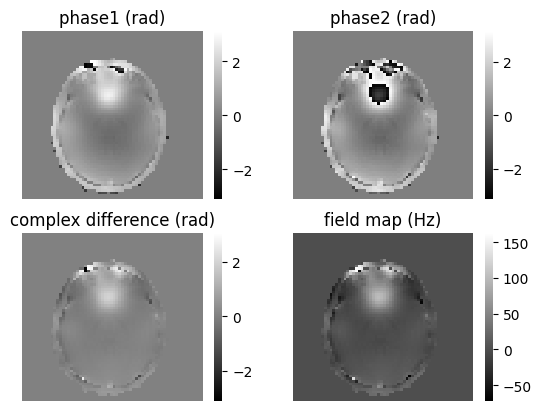

In [ ]:
%matplotlib inline
delta_te = (echo_times[1] - echo_times[0])
field_map1 = (unwraped_phase_diff/(2*np.pi*delta_te))*mask2  # [Hz]


plt.subplot(2,2,1)
sns.heatmap(np.rot90(phase1[...,20], k=1), cmap='gray', xticklabels=False, yticklabels=False), plt.title('phase1 (rad)'), 
plt.subplot(2,2,2)
sns.heatmap(np.rot90(phase2[...,20], k=1), cmap='gray',  xticklabels=False, yticklabels=False), plt.title('phase2 (rad)')
plt.subplot(2,2,3)
sns.heatmap(np.rot90(phase_diff_con[...,20], k=1), cmap='gray', xticklabels=False, yticklabels=False), plt.title('complex difference (rad)')
plt.subplot(2,2,4)
sns.heatmap(np.rot90(field_map1[...,20], k=1), cmap='gray', xticklabels=False, yticklabels=False), plt.title('field map (Hz)'), plt.colorbar

(field_map1.shape)[2]

plt.savefig('double_echo.png')

## Multi-echo field mapping

The data used here was not available for public. However the user can still follow the steps here and can use his own data to reproduce the results.

In [ ]:
## Unwrapping takes a few minutes! 

mag1 = read_nii(os.path.join(path,"BR_e1_M.nii"))[2]
phase_list_nii = [nib.load(os.path.join(path, "BR_e"+str(i)+"_ph.nii")) for i in range(1,5)]
phase_list_data = [phase_list_nii[i].get_fdata() for i in range(len(phase_list_nii))]

scaled_phase_list_data = [((phase_list_data[i] - np.min(phase_list_data[i]))/(np.max(phase_list_data[i])-np.min(phase_list_data[i])))
                         *2*np.pi-np.pi for i in range(len(phase_list_data))]

scaled_phase_list_nii = [nib.Nifti1Image(scaled_phase_list_data[i], phase_list_nii[0].affine, phase_list_nii[0].header)
                         for i in range(len(scaled_phase_list_data))]

mask3 = mask_threshold(mag1, thr= 0.05 * (mag1.max() - mag1.min()))

unwraped_phase_list_data = [unwrap_phase(scaled_phase_list_nii[i], unwrapper = 'prelude', mag=mag1, mask=mask3)
                       for i in range(len(scaled_phase_list_nii))]

unwraped_phase_list_nii = [nib.Nifti1Image(unwraped_phase_list_data[i], phase_list_nii[0].affine, phase_list_nii[0].header)
                           for i in range(len(unwraped_phase_list_data))]
unwrap_phase1 = unwraped_phase_list_data[0]                         

In [ ]:
reshaped_previous_phase = unwrap_phase1.reshape(-1,1).T
reshaped_mask = mask3.reshape(-1,1).T

for echo in range(1,4):
    new_reshaped_phase = (scaled_phase_list_data[echo]*mask3).reshape(-1,1).T
    reshaped_phases = np.concatenate((reshaped_previous_phase, new_reshaped_phase), axis=0)
    for voxel in range(len(reshaped_phases[1])):
        if reshaped_mask[0,voxel]>0:
          n_offsets = np.round((reshaped_phases[echo, voxel] - reshaped_phases[echo-1, voxel])/(2*np.pi))
          reshaped_phases[echo, voxel] -= n_offsets *2* np.pi
                             
        
    reshaped_previous_phase = reshaped_phases
    
np.shape(reshaped_phases)   


(4, 409600)

In [ ]:
X = np.asarray(echo_times_4)
reg = LinearRegression().fit(X.reshape(-1, 1), reshaped_phases)
# # # Slope of linear regression reshaped into the shape of original 3D phase.
slope = reg.coef_.reshape(unwrap_phase1.shape)  # the initial slope in [rad / s]
new_fieldmap = slope / (2*np.pi) # field map in Hz
new_fieldmap_nii = nib.Nifti1Image(new_fieldmap, phase_list_nii[0].affine, phase_list_nii[0].header)
nib.save(new_fieldmap_nii, 'new_fieldmap')

In [ ]:
## Running this code returns a tuple including the fieldmap and the mask respectively.
st_fieldmap = prepare_fieldmap(scaled_phase_list_nii, echo_times_4, mag1, unwrapper='prelude', mask=mask3)
st_fieldmap_nii = nib.Nifti1Image(st_fieldmap[0], phase_list_nii[0].affine, phase_list_nii[0].header)
nib.save(st_fieldmap_nii, 'st_fieldmap')

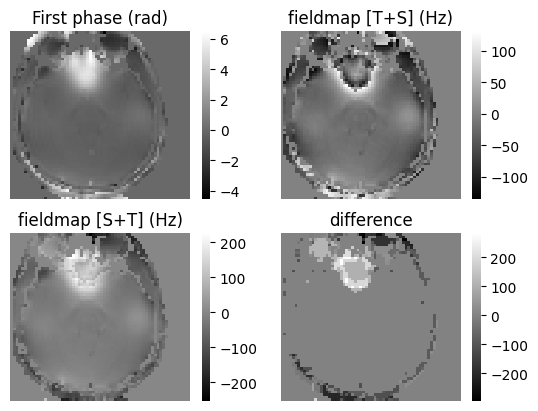

In [ ]:
%matplotlib inline
plt.subplot(2,2,1)
sns.heatmap(np.rot90(unwrap_phase1[...,40], k=1), cmap='gray', xticklabels=False, yticklabels=False), plt.title('First phase (rad)'), 
plt.subplot(2,2,2)
sns.heatmap(np.rot90(new_fieldmap[...,40], k=1), cmap='gray', xticklabels=False, yticklabels=False), plt.title('fieldmap [T+S] (Hz)'), 
plt.subplot(2,2,3)
sns.heatmap(np.rot90(st_fieldmap[0][...,40], k=1), cmap='gray',  xticklabels=False, yticklabels=False), plt.title('fieldmap [S+T] (Hz)')
plt.subplot(2,2,4)
sns.heatmap(np.rot90(st_fieldmap[0][...,40]-new_fieldmap[...,40], k=1), cmap='gray',  xticklabels=False, yticklabels=False), plt.title('difference')
plt.savefig('linear_fitting.png')

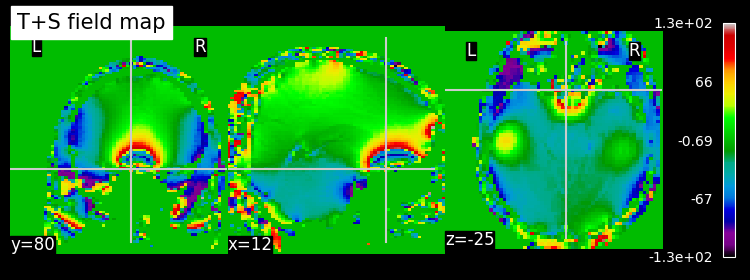

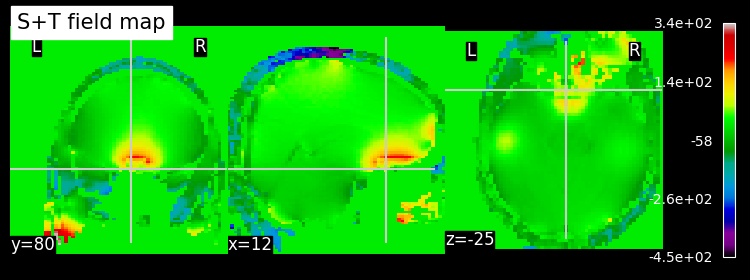

In [ ]:
%matplotlib inline

plot_epi(new_fieldmap_nii, cut_coords=[12, 80, -25], colorbar=True, title='T+S field map')
plt.savefig('linear_fitting_new_method.png')
plot_epi(st_fieldmap_nii, cut_coords=[12, 80, -25], colorbar=True, title='S+T field map')
plt.savefig('linear_fitting_st.png')

## EPI fieldmapping

In [ ]:

layout = BIDSLayout('ds001600')

EPI_AP_nii_path = layout.get(acquisition= 'AP',
                            datatype = 'func',
                            extension = 'nii.gz',
                            )

EPI_AP_json_path = layout.get(acquisition= 'AP',
                            datatype = 'func',
                            extension = '.json',
                            )

EPI_PA_nii_path = layout.get(direction= 'PA',
                            datatype = 'fmap',
                            extension = 'nii.gz',
                            suffix= 'epi')
EPI_PA_json_path = layout.get(direction= 'PA',
                            datatype = 'fmap',
                            extension = '.json',
                            suffix= 'epi')

dic = json.load(open(EPI_AP_json_path[0]))

TotalReadoutTime = (dic['TotalReadoutTime'])


EPI_AP_nii_path = re.findall(r"'([^']*)'", str(EPI_AP_nii_path))
EPI_PA_nii_path = re.findall(r"'([^']*)'", str(EPI_PA_nii_path))

EPI_AP_nii = nib.load(EPI_AP_nii_path[0])
EPI_PA_nii = nib.load(EPI_PA_nii_path[0])

EPI_AP_1 = EPI_AP_nii.get_fdata()[...,0]

EPI_PA_nii = nib.load(EPI_PA_nii_path[0])

EPI_PA_1 = EPI_PA_nii.get_fdata()[...,0]


EPI_PA_1_nii = nib.Nifti1Image(EPI_PA_1, EPI_PA_nii.affine, EPI_PA_nii.header)
EPI_AP_1_nii = nib.Nifti1Image(EPI_AP_1, EPI_AP_nii.affine, EPI_AP_nii.header)

nib.save(EPI_PA_1_nii, 'EPI_PA')
nib.save(EPI_AP_1_nii, 'EPI_AP')

mask4 = mask_threshold(EPI_PA_1, thr= 0.05 * (EPI_PA_1.max() - EPI_PA_1.min()))


In [ ]:
# Merge two EPI volumes in forth dimension
!fslmerge -t merged_EPIs.nii EPI_AP.nii EPI_PA.nii

In [ ]:
# first three elements in Acquisition_info shows the phase encoding direction and
# first row means PE for the first EPI volume is along y and AP and
# second line shows PE in second EPI is along y and PA.

Acquisition_info = (0, 1, 0, TotalReadoutTime,
                   0, -1, 0,  TotalReadoutTime)

file = open("Acquisition_info.txt", "w+")
 
# Saving the array in a text file
file.write(" ".join(map(str, Acquisition_info[:4])) + "\n")
file.write(" ".join(map(str, Acquisition_info[4:])))
file.close()

In [ ]:
!topup --imain=merged_EPIs.nii --datain=Acquisition_info.txt --config=b02b0.cnf --fout=FSL_fieldmap_Hz2 --iout=Corrected_EPI


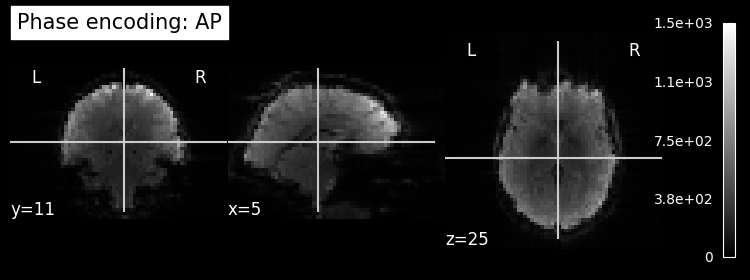

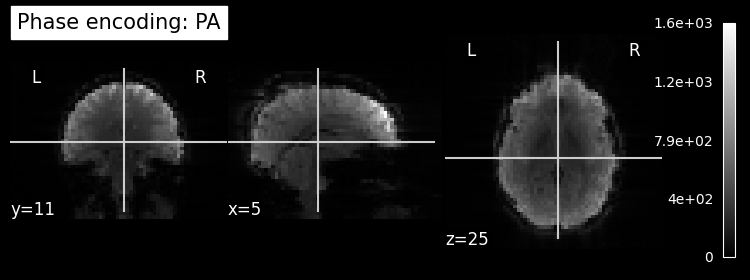

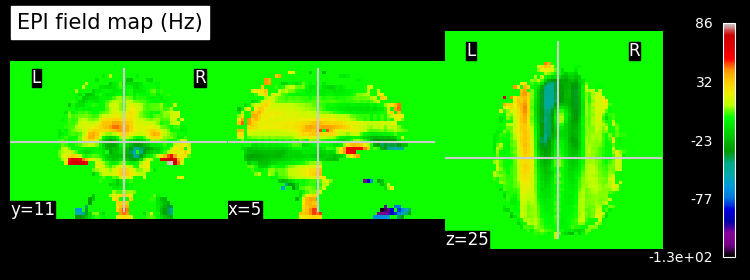

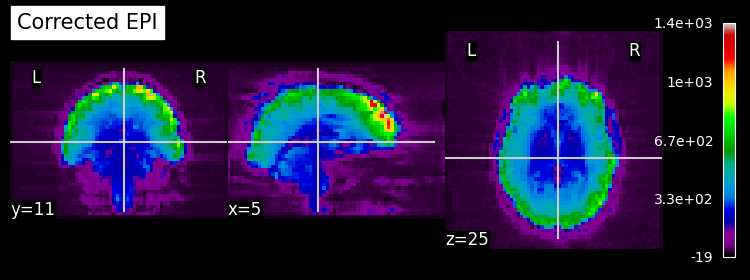

In [ ]:
%matplotlib inline
FSL_fieldmap_Hz = nib.load('FSL_fieldmap_Hz2.nii.gz').get_fdata()* mask4
FSL_fieldmap_nii = nib.Nifti1Image(FSL_fieldmap_Hz, EPI_AP_nii.affine, EPI_AP_nii.header)

plot_epi(nib.load('EPI_AP.nii'), cut_coords=[5, 11, 25], colorbar=True, title='Phase encoding: AP', cmap='gray')
plt.savefig('EPI_AP.png')

plot_epi(nib.load('EPI_PA.nii'), cut_coords=[5, 11, 25], colorbar=True, title='Phase encoding: PA', cmap='gray')
plt.savefig('EPI_PA.png')

plot_epi(FSL_fieldmap_nii, cut_coords=[5, 11, 25], colorbar=True, title='EPI field map (Hz)')
plt.savefig('EPI_field_map.png')

plot_epi(nib.load('Corrected_EPI.nii.gz').slicer[...,0:1], cut_coords=[5, 11, 25], cmap='gray', colorbar=True, title='Corrected EPI')
plt.savefig('Corrected_EPI.png')




## rs-fMRI correction

 Clonning data set from Open neuro website using datalad. 
Note that one of the files in this dataset is corrupted and you would see an erorr at the end of retriving the data. As we are not using that file just ignore the erorr message. 


In [ ]:
dl.clone(source='https://github.com/OpenNeuroDatasets/ds000172.git')
dataset_path = os.path.join(os.getcwd(),'ds000172', 'sub-control02') 
os.chdir(dataset_path)
dl.get(dataset_path)


### Data_preperation

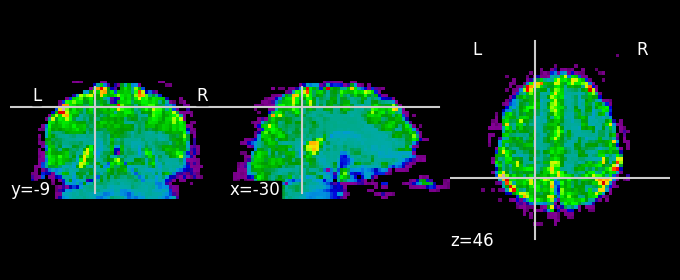

In [ ]:
os.chdir('/content')
Layout = BIDSLayout('ds000172')

phasediff_nii_path = Layout.get(subject= 'control02',
                             suffix= 'phasediff',
                            datatype = 'fmap',
                            extension = 'nii.gz',
                            )

phasediff_json_path = Layout.get(subject= 'control02',
                            datatype = 'fmap',
                            extension = '.json',
                            suffix= 'phasediff')

Magnitude_nii_path = Layout.get(subject= 'control02',
                             suffix= 'magnitude2',
                            datatype = 'fmap',
                            extension = 'nii.gz',
                            )
Bold_nii_path = Layout.get(subject= 'control02',
                            task= 'rest',
                            acquisition= 'voxelsize333',
                            suffix = 'bold',
                            extension = 'nii.gz',
                            )

Bold_json_path = Layout.get(subject= 'control02',
                            acquisition= 'voxelsize333',
                            suffix = 'bold',
                            extension = '.json',
                            )

T1_path = Layout.get(subject= 'control02',
                            suffix= 'T1w',
                            datatype = 'anat',
                            extension = '.nii.gz',
                            )

phasediff_nii_path = re.findall(r"'([^']*)'", str(phasediff_nii_path))
Magnitude_nii_path = re.findall(r"'([^']*)'", str(Magnitude_nii_path))
Bold_nii_path = re.findall(r"'([^']*)'", str(Bold_nii_path))
T1_path = re.findall(r"'([^']*)'", str(T1_path[1]))


Magnitude_nii = nib.load(Magnitude_nii_path[0])
phasediff_nii = nib.load(phasediff_nii_path[0])
Bold_nii = nib.load(Bold_nii_path[0])
T1_nii = nib.load(T1_path[0])


phasediff = phasediff_nii.get_fdata()
Magnitude = Magnitude_nii.get_fdata()
Bold = Bold_nii.get_fdata()
T1= T1_nii.get_fdata()

mask4 = mask_threshold(Magnitude, thr= 0.04 * (Magnitude.max() - Magnitude.min()))
phasediff_scaled = ((phasediff - np.min(phasediff))/(np.max(phasediff)-np.min(phasediff)))*2*np.pi -np.pi

mask5 = mask_threshold(Bold[...,0], thr= 0.04 * (Bold[...,0].max() - Bold[...,0].min()))
mask5 = np.repeat(mask5[..., np.newaxis], Bold.shape[3], axis=3)

Bold2 = Bold_nii.get_fdata()*mask5
dic1 = json.load(open(phasediff_json_path[0]))
dic2 = json.load(open(Bold_json_path[0]))

TE_1 = (dic1['EchoTime1'])
TE_2 = (dic1['EchoTime2'])


dwell_time = (dic2['EffectiveEchoSpacing'])

echo_diff = TE_2 - TE_1
fieldmap_fmri = (phasediff_scaled/echo_diff)* mask4 # rad/s

fieldmap_fmri_nii = nib.Nifti1Image(fieldmap_fmri, phasediff_nii.affine, phasediff_nii.header)
nib.save(fieldmap_fmri_nii, 'fieldmap_fmri')
Bold2_nii = nib.Nifti1Image(Bold2, Bold_nii.affine, Bold_nii.header)
nib.save(Bold2_nii,'Bold_v333')
nib.save(T1_nii,'T1')

fieldmap_mask = nib.Nifti1Image(mask4, phasediff_nii.affine, phasediff_nii.header )
nib.save(fieldmap_mask, 'fieldmap_mask')
plot_epi(Bold2_nii.slicer[...,0:1])

### Corrected rs-fMRI connectivity analysis

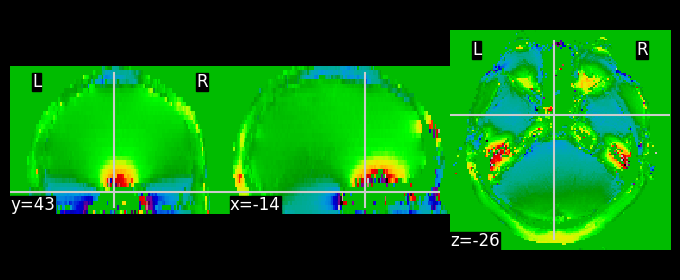

In [ ]:
plot_epi(nib.load('fieldmap_fmri.nii'))

#### Registering fieldmap to MNI space

In [ ]:
!cp /cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.4_20210105/fsl_6.0.4_20210105.simg/opt/fsl-6.0.4/data/linearMNI/MNI152lin_T1_2mm.nii.gz /content/
!flirt -in fieldmap_fmri.nii -ref MNI152lin_T1_2mm.nii.gz  -out fieldmap_2_MNI.nii.gz -omat fieldmap_2_MNI.mat  -bins 256 -cost normmi -searchcost normmi -searchrx -90 90 -searchry -90 90 -searchrz -90 90 -dof 12 -interp sinc -sincwidth 7 -sincwindow hanning

 Here you need to manually enter the value of echo spacing (dwell_time) which is extracted from the data in previous cell and is equal to 0.00086 s. 

In [ ]:
!flirt -in Bold_v333.nii  -ref MNI152lin_T1_2mm.nii.gz -dof 12  -out Bold_2_MNI_1st_vol -omat Bold_2_MNI_1st_vol.mat -cost normmi -searchcost normmi -fieldmap fieldmap_2_MNI.nii.gz -fieldmapmask fieldmap_mask.nii -pedir -2 -echospacing 0.00086


ERROR::set_bbr_seg: could not find any boundary points!


Applying the transformation matrix from previous step to whole Bold volumes.

In [ ]:
!flirt -ref fieldmap_2_MNI.nii.gz -in Bold_v333.nii -init Bold_2_MNI_1st_vol.mat -applyxfm -out Bold_undistorted.nii.gz

#### Plotting the corrected fMRI as an overlay on T1w MNI.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



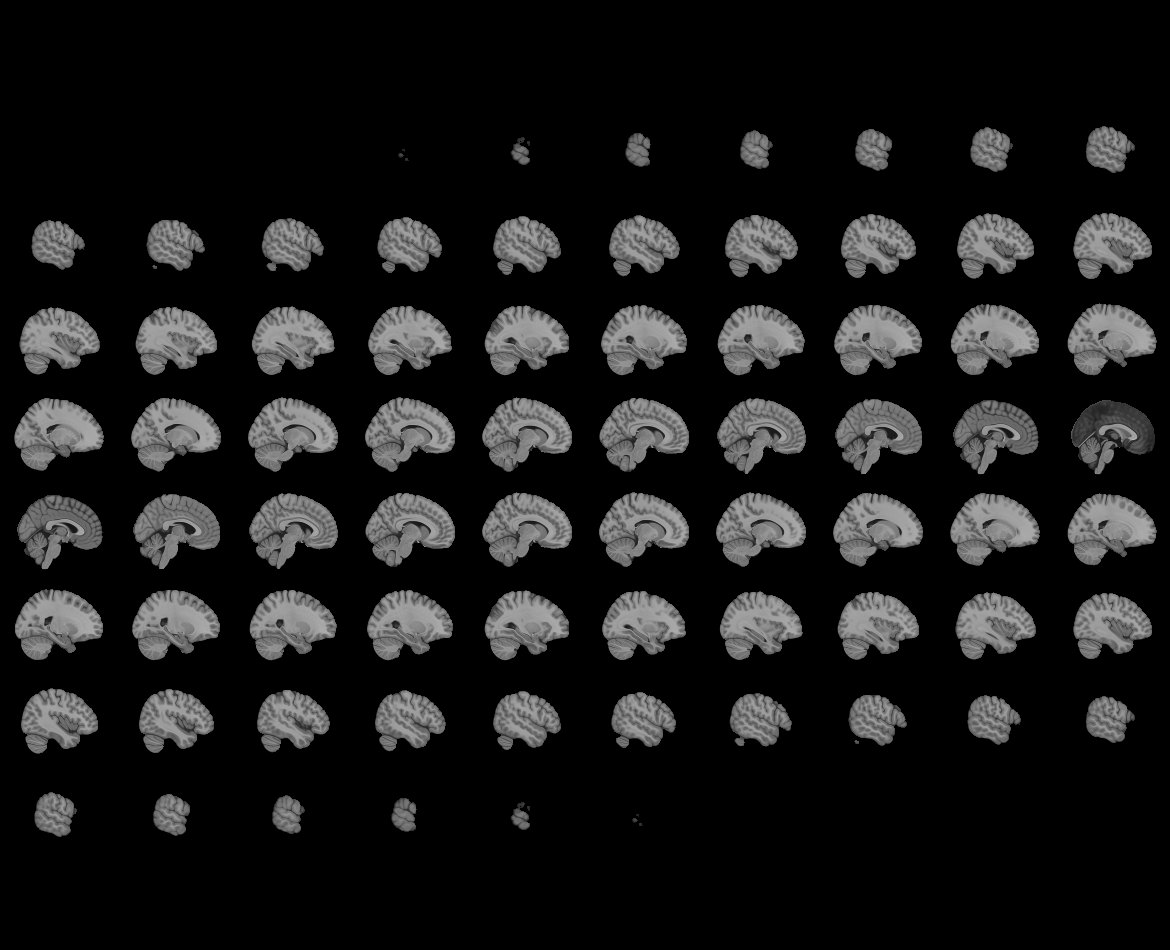
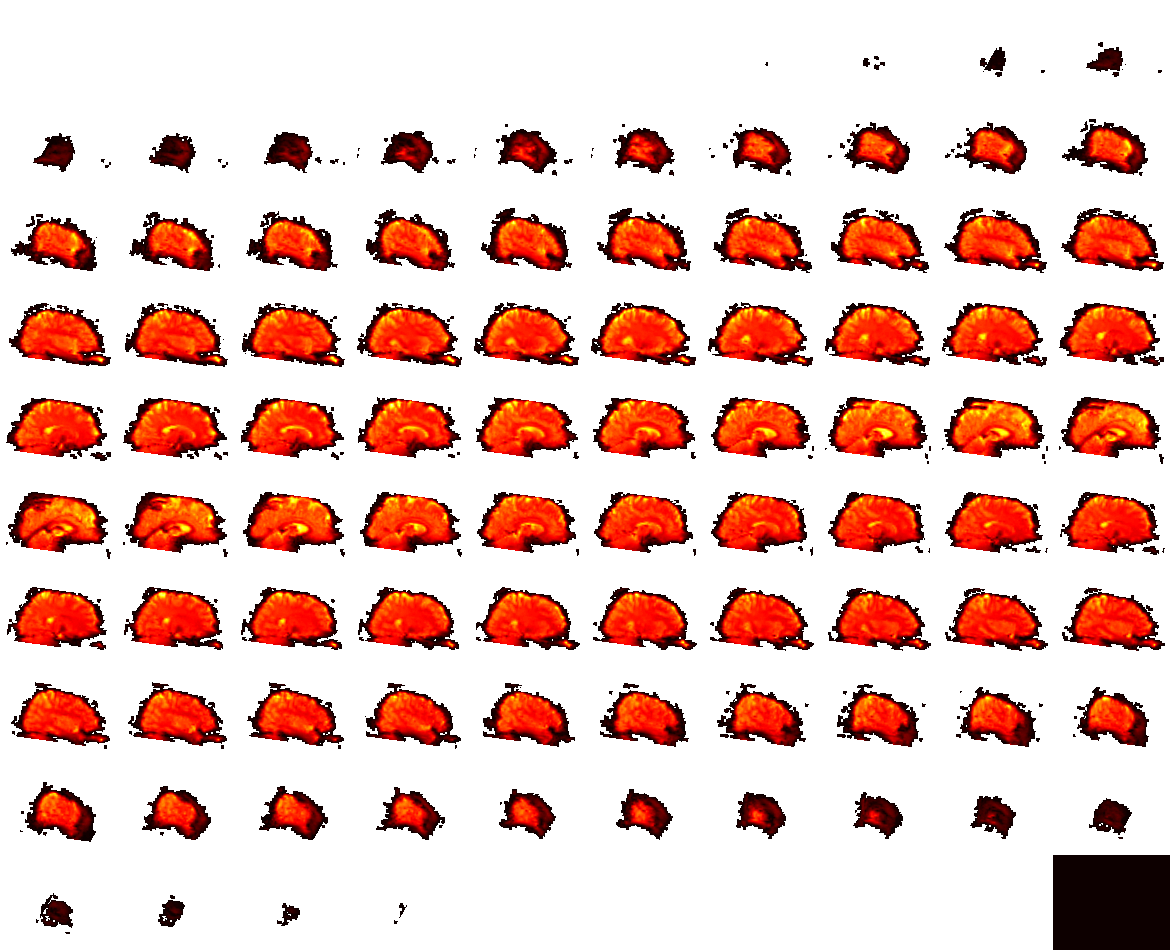

In [ ]:
Bold_undistorted_nii = nib.load('Bold_undistorted.nii.gz')
view_img(Bold_undistorted_nii.slicer[...,0:1])

In [ ]:
img = view_img(Bold_undistorted_nii.slicer[...,0:1])
img.save_as_html("MNI_overlay.html")

In [ ]:
from nilearn.input_data import NiftiMasker

corrected_bold_nii = nib.load('Bold_undistorted.nii.gz')
corrected_bold = corrected_bold_nii.get_fdata()
print(corrected_bold.shape)

masker1 = NiftiMasker()
masked_data1 = masker1.fit_transform(corrected_bold_nii)
print(masked_data1.shape)
print(type(masked_data1))

(91, 109, 91, 150)
(150, 283347)
<class 'numpy.ndarray'>


In [ ]:
thresholded_masked_data1 = masked_data1 * (masked_data1 > 0.1* masked_data1.mean())
thresholded_img1 = masker1.inverse_transform(thresholded_masked_data1)

In [ ]:
from nilearn import datasets

data_dir = os.getcwd # change this variable with the path where you want nilearn to download
                # the data, if you leave None, the default will be '~/nilearn_data'
    
# Loading the functional datasets
data = datasets.fetch_development_fmri(n_subjects=1, data_dir=data_dir)

# you can use the .keys() method to check what's in the dataset
data.keys()


Dataset created in <built-in function getcwd>/development_fmri


Dataset created in <built-in function getcwd>/development_fmri/development_fmri



 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [ ]:
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels


Dataset created in <built-in function getcwd>/msdl_atlas



 ...done. (1 seconds, 0 min)
Extracting data from <built-in function getcwd>/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.


In [ ]:
from nilearn.input_data import NiftiMapsMasker

atlas_masker1 = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)
data_in_atlas1 = atlas_masker1.fit_transform(corrected_bold_nii)
data_in_atlas1.shape


/usr/local/lib/python3.10/dist-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(150, 39)

/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


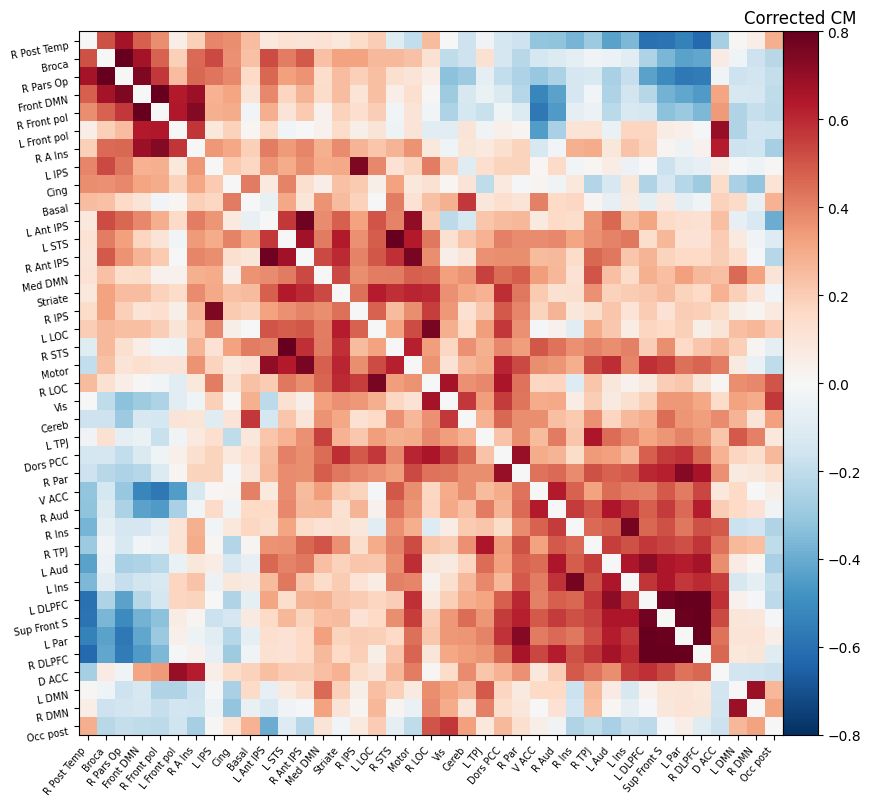

In [ ]:
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas1])[0]

# Plot the correlation matrix
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True), plt.title('Corrected CM')

plt.savefig('Corrected_CM.png')

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



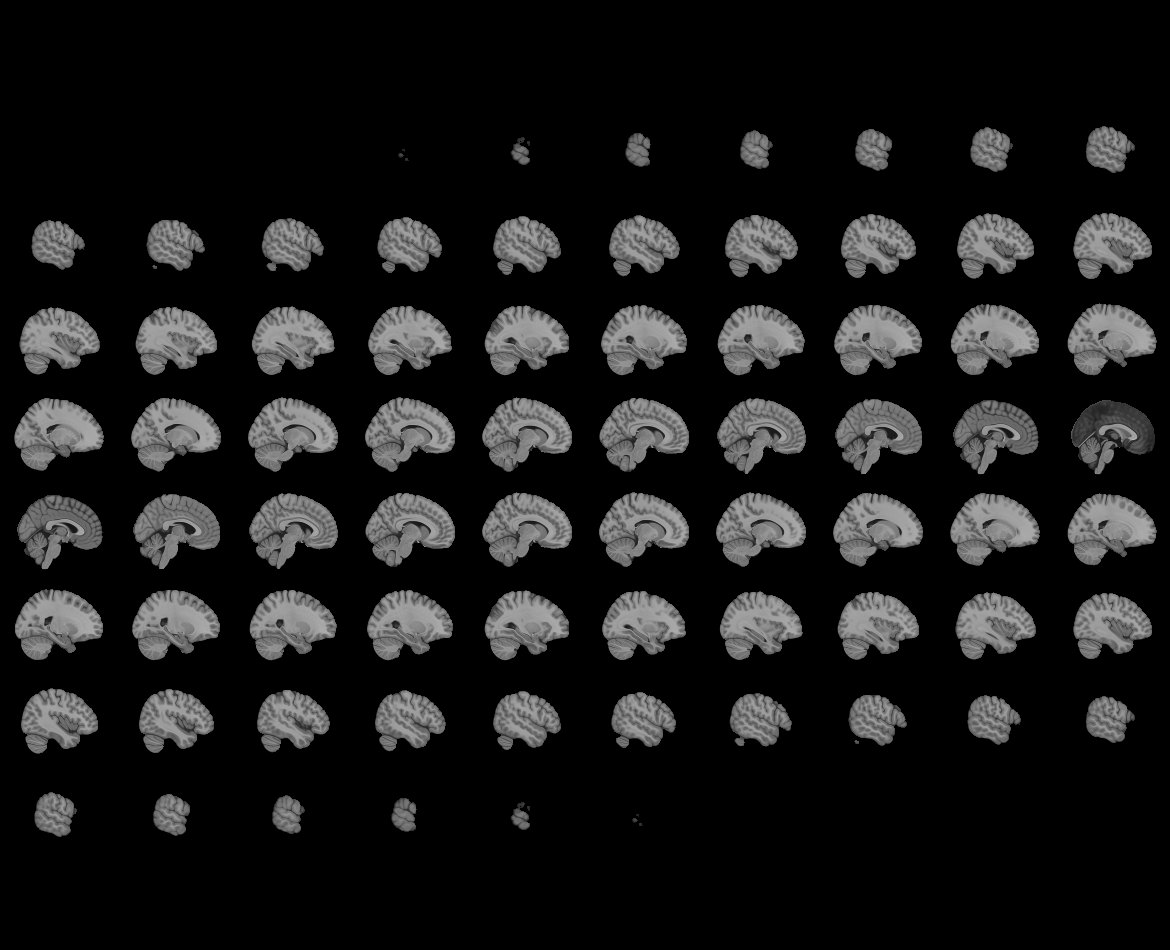
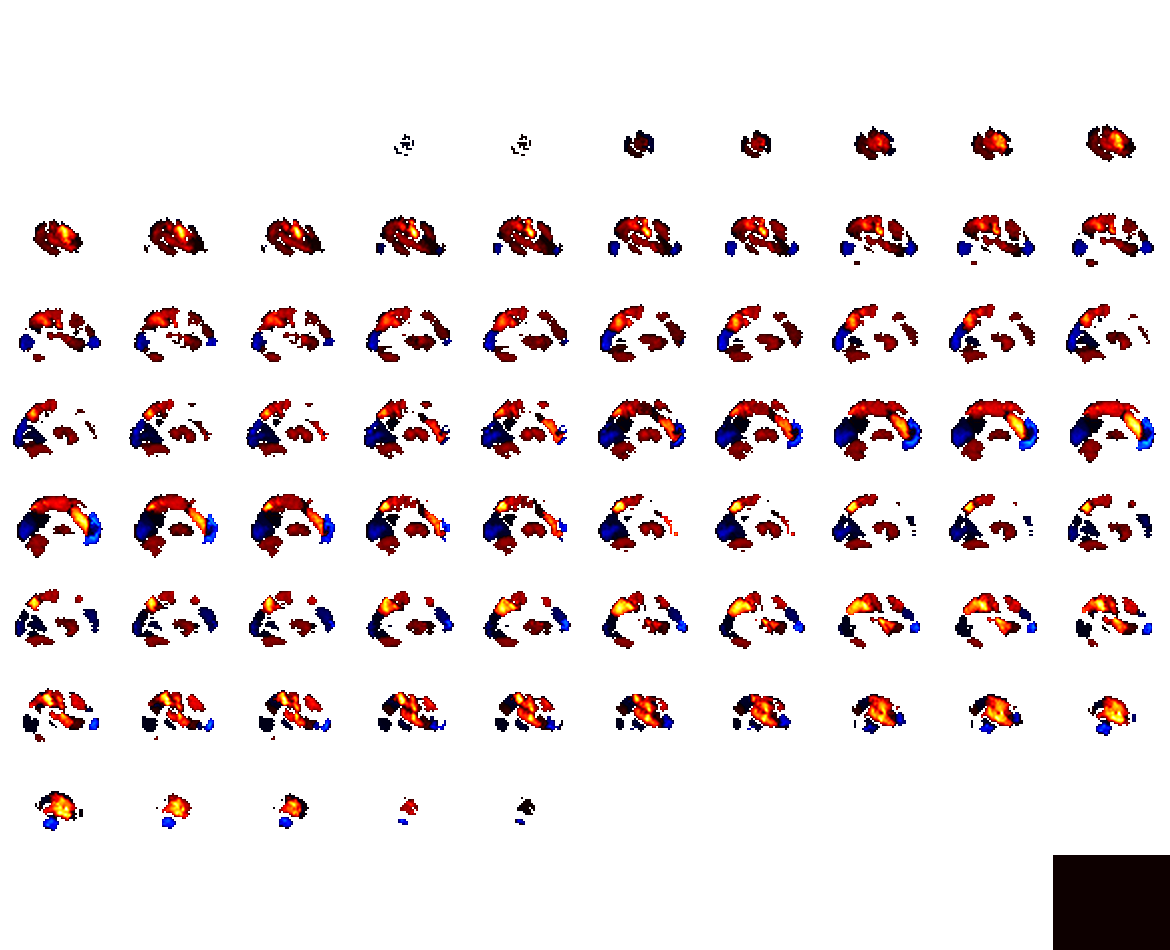

In [ ]:
img = atlas_masker1.inverse_transform(data_in_atlas1)

view_img(img.slicer[...,5])


### Uncorrected rs-fMRI connectivity analysis

In [ ]:
from nilearn.input_data import NiftiMasker

bold_nii = nib.load('Bold_v333.nii')
bold = bold_nii.get_fdata()


masker = NiftiMasker()
masked_data = masker.fit_transform(bold_nii)
print(masked_data.shape)


(150, 53180)
<class 'numpy.ndarray'>


In [ ]:
thresholded_masked_data = masked_data * (masked_data > 0.1* masked_data.mean())

thresholded_img = masker.inverse_transform(thresholded_masked_data)


In [ ]:
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels

In [ ]:
from nilearn.input_data import NiftiMapsMasker

atlas_masker = NiftiMapsMasker(maps_img= atlas_filepath, standardize=True)
data_in_atlas = atlas_masker.fit_transform(bold_nii)
data_in_atlas.shape

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(150, 39)

/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


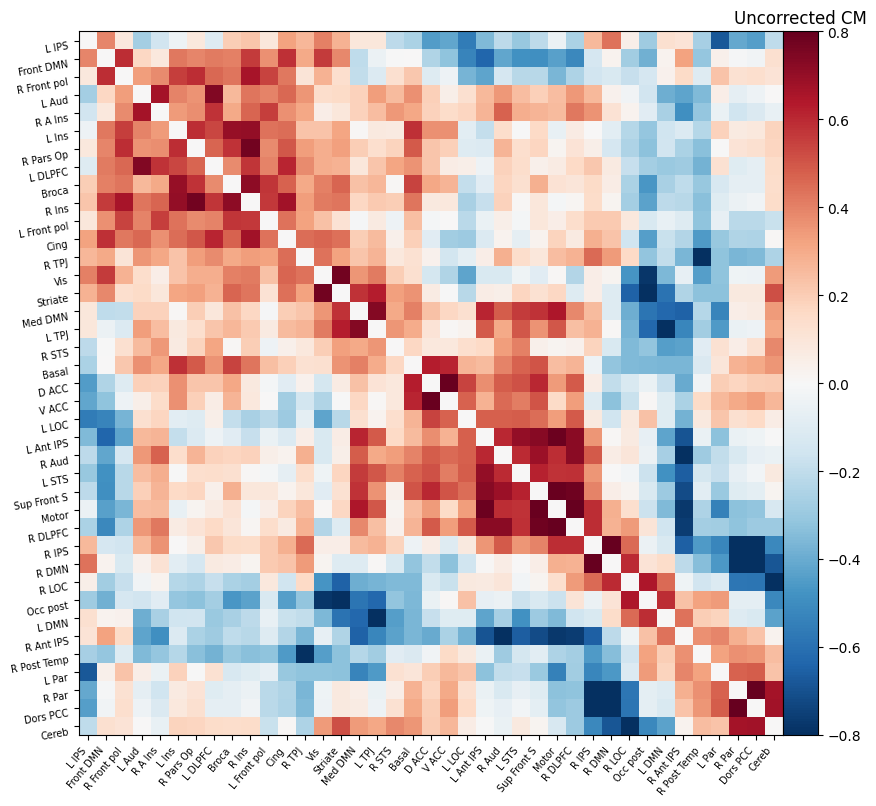

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure2 = ConnectivityMeasure(kind='correlation')
correlation_matrix2 = correlation_measure2.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix

from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix2, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix2, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True), plt.title('Uncorrected CM')

plt.savefig('Uncorrected_CM.png')

### Comparison

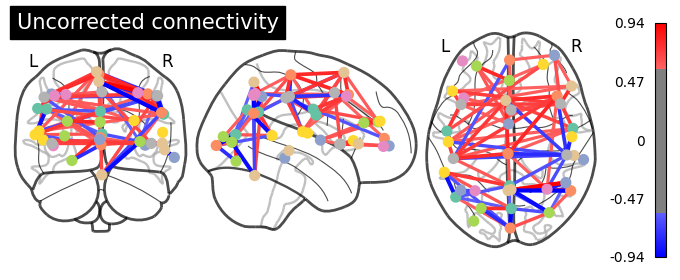

In [ ]:
from nilearn.plotting import plot_connectome

coords = atlas_dataset.region_coords

# We threshold to keep only the 10% of edges with the highest value
# because the graph is very dense
plot_connectome(correlation_matrix2, coords,
                edge_threshold="90%", colorbar=True, title="Uncorrected connectivity")
plt.savefig('Uncorrected_connectivity.png')

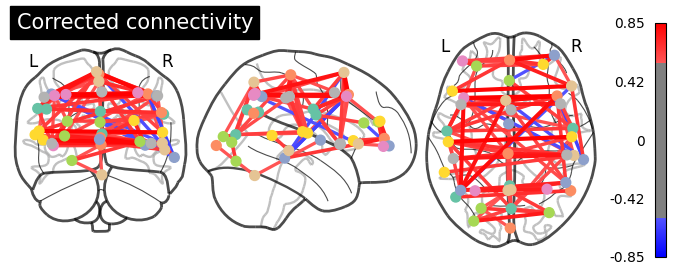

In [ ]:
from nilearn.plotting import plot_connectome

coords = atlas_dataset.region_coords

# We threshold to keep only the 10% of edges with the highest value
# because the graph is very dense
plot_connectome(correlation_matrix, coords,
                edge_threshold="90%", colorbar=True, title="Corrected connectivity")
plt.savefig('corrected_connectivity.png')

In [ ]:
plotting.view_connectome(correlation_matrix2, coords, edge_threshold="80%", title="Uncorrected connectivity")
 

In [ ]:
# Saving it to html
interactive = plotting.view_connectome(correlation_matrix2, coords, edge_threshold="80%", title="Uncorrected connectivity")
interactive.save_as_html("connectivity1.html") 

In [ ]:
plotting.view_connectome(correlation_matrix, coords,edge_threshold="80%", title=" Corrected connectivity")

/usr/local/lib/python3.10/dist-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '


In [ ]:
# Saving it to html
interactive_fig = plotting.view_connectome(correlation_matrix, coords,edge_threshold="80%", title=" Corrected connectivity")
interactive_fig.save_as_html("connectivity.html")